# US Election Tweets Clustering - Other Approaches

**These were just some alternative approaches I tried early in the project. See the clustering on the main repo page for the final result.**

I attempted clustering using 3 different methods on document vectors using cosine dissimilarity as a distance metric: Agglomerative clustering, HDBSCAN and OPTICS.

Agglomerative clustering failed to identify any latent grouping structure. HDBSCAN consistently identified a grouping with the right parameters. However I found that as I added more data, only one of the groupings grew. This likely indicated that there were tweets with similar information picked up during a part of the scrape, which did not continue further on in the scrape.

OPTICS provided a reasonably even split into two clusters. While there were slightly different characteristics observed between clusters, the split was not obvious. This is likely due to the low max_eps parameter used.

I ended up running an analysis on the HDBSCAN clusters, and two different sets of OPTICS clusters. There were definitely some interesting results, although far from conclusive. 


In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import spacy
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import time

from sklearn.cluster import AgglomerativeClustering, OPTICS
from hdbscan import HDBSCAN

df=pd.read_csv('Master_word_vectors.csv', index_col=0)
df.drop('contents', axis=1, inplace=True)
df.head()
print(df.shape)

(15326, 300)


# Preparation for Clustering

In [5]:
#cosine distance matrix
test=np.array(df)
test_sparse=sparse.csr_matrix(test)
similarities=1-cosine_similarity(test_sparse)
for i in range(len(similarities)):
    similarities[i][i]=0  #correct floating point error
similarities[similarities<0]=0

array([[0.        , 0.04966144, 0.03692526, ..., 0.04320809, 0.50615834,
        0.46415503],
       [0.04966144, 0.        , 0.02931876, ..., 0.06153515, 0.48742762,
        0.51195318],
       [0.03692526, 0.02931876, 0.        , ..., 0.04652277, 0.48355522,
        0.47618826],
       ...,
       [0.04320809, 0.06153515, 0.04652277, ..., 0.        , 0.48728537,
        0.42323565],
       [0.50615834, 0.48742762, 0.48355522, ..., 0.48728537, 0.        ,
        0.63432309],
       [0.46415503, 0.51195318, 0.47618826, ..., 0.42323565, 0.63432309,
        0.        ]])

# Agglomerative Clustering

In [7]:
model=AgglomerativeClustering(n_clusters=3, affinity='precomputed',linkage='average').fit(similarities)
labels_agg=model.labels_
for label in np.unique(labels_agg):
    print(label,':',len(labels_agg[labels_agg==label]))

0 : 15322
1 : 1
2 : 3


# HDBSCAN

In [8]:
start=time.time()
model=HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=0.1, metric='precomputed',gen_min_span_tree=True).fit(similarities)
labels_hdb=model.labels_
print('Clustering took: ',time.time()-start, ' seconds.')
for label in np.unique(labels_hdb):
    print(label,':',len(labels_hdb[labels_hdb==label]))

Clustering took:  115.7927827835083  seconds.
-1 : 1047
0 : 14173
1 : 106


# OPTICS

In [9]:
#model1
start=time.time()
model_test=OPTICS(min_samples=200, max_eps=0.1,metric="precomputed",cluster_method='xi', xi=0.05, min_cluster_size=None, n_jobs=-1).fit(similarities)
labels_opt_one=model_test.labels_
print('Clustering took: ',time.time()-start, ' seconds.')
for label in np.unique(labels_opt_one):
    print(label,':',len(labels_opt_one[labels_opt_one==label]))

Clustering took:  1467.9597771167755  seconds.
-1 : 1811
0 : 13515


In [10]:
#model2
start=time.time()
model_test=OPTICS(min_samples=200, max_eps=0.05,metric="precomputed",cluster_method='xi', xi=0.05, min_cluster_size=None, n_jobs=-1).fit(similarities)
labels_opt_two=model_test.labels_
print('Clustering took: ',time.time()-start, ' seconds.')
for label in np.unique(labels_opt_two):
    print(label,':',len(labels_opt_two[labels_opt_two==label]))

Clustering took:  637.2589018344879  seconds.
-1 : 6700
0 : 8626


# Visualisation

In [11]:
labels_agg_df=pd.DataFrame(labels_agg, columns=['Cluster'])
labels_hdb_df=pd.DataFrame(labels_hdb, columns=['Cluster'])
labels_opt_one_df=pd.DataFrame(labels_opt_one, columns=['Cluster'])
labels_opt_two_df=pd.DataFrame(labels_opt_two, columns=['Cluster'])

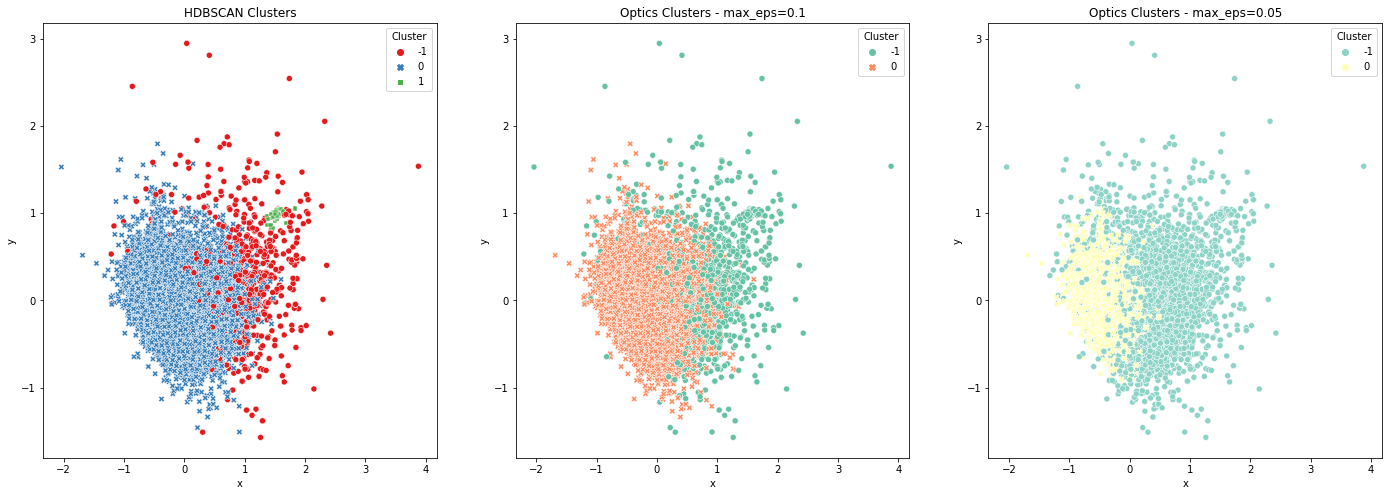

In [14]:
pca=PCA(n_components=2)
pca.fit(df)
pca_vec=pca.transform(df)
pca_vec_df=pd.DataFrame(pca_vec, columns=['x','y'])

plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
plt.title('HDBSCAN Clusters')
sns.scatterplot(data=pca_vec_df, x='x', y='y', hue=labels_hdb_df['Cluster'], style=labels_hdb_df['Cluster'], palette='Set1')

plt.subplot(1,3,2)
plt.title('Optics Clusters - max_eps=0.1')
sns.scatterplot(data=pca_vec_df, x='x', y='y', hue=labels_opt_one_df['Cluster'], style=labels_opt_one_df['Cluster'], palette='Set2')

plt.subplot(1,3,3)
plt.title('Optics Clusters - max_eps=0.05')
sns.scatterplot(data=pca_vec_df, x='x', y='y', hue=labels_opt_two_df['Cluster'], style=labels_opt_two_df['Cluster'], palette='Set3');


In [1]:
mast=pd.read_csv('Election_Tweets_Master.csv',index_col=0)
mast_clust_hdb=pd.concat([mast, labels_hdb_df], axis=1)
mast_clust_opt1=pd.concat([mast,labels_opt_one_df],axis=1)
mast_clust_opt2=pd.concat([mast,labels_opt_two_df],axis=1)
mast_clust_hdb.to_csv('Election_Tweets_Clustered_HDBSCAN.csv')
mast_clust_opt1.to_csv('Election_Tweets_Clustered_OPTICS1.csv')
mast_clust_opt2.to_csv('Election_Tweets_Clustered_OPTICS2.csv')